In [1]:
import numpy as np
import h5py
import h5io
import matplotlib.pyplot as plt
import ecogtools as et
%matplotlib inline

/Users/choldgraf/anaconda/lib/python2.7/site-packages/brian/utils/sparse_patch/__init__.py:39: UserWarning: Couldn't find matching sparse matrix patch for scipy version 0.16.1, but in most cases this shouldn't be a problem.
  warnings.warn("Couldn't find matching sparse matrix patch for scipy version %s, but in most cases this shouldn't be a problem." % scipy.__version__)
/Users/choldgraf/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


When analyzing the brain, it's important to choose a visualization that lets you localize an effect to a particular region of the brain. This way you can make statements about how processing is localized to one region or another.

This means that in neuroscience, you often see images like this:

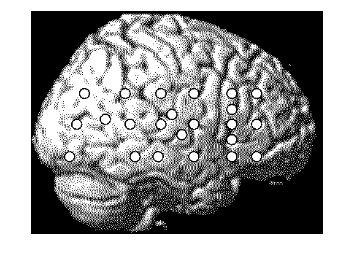

In [2]:
im = plt.imread('./data/surface/mni_brain.gif')
f, ax = plt.subplots()
ax.imshow(im)
ax.set_axis_off()

If we know the coordinates of points where activity occurs, we can plot on top of brains like this:

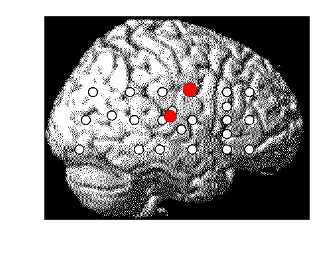

In [3]:
xy = np.array([[190, 150], [220, 110]])
ax.scatter(*xy.T, s=[150, 200], color='r', edgecolor='k')
f

However, sometimes we want a more rich display of activity on the brain. Fortunately, it is now possible to do this with plot.ly

# 3d brains in plotly
Plotly is a platform for language-agnostic interactive plotting. They've recently [open-sourced](https://plot.ly/javascript/open-source-announcement/) their entire codebase, which has led to a lot of improvements from the community. One such improvement has recently been made to the speed of 3D plotting making it possible to render high-resolution 3D images (like a brain!).

We'll load some modules in plotly and show how easy this is.

*an important note: brain plotting is best done locally, within a jupyter notebook. Plotly has libraries for offline plotting, which avoid needing to send the data to plotly's servers first*

In [4]:
from plotly.tools import FigureFactory as ff
import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl
from plotly import tools as to
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

In [5]:
# We'll initialize plotly's offline mode so that our data isn't sent to the cloud
init_notebook_mode()

Now, we'll load a surface model of the brain. This is comprised of:

* xyz coordinates of points in a 3-D space
* an n_triangles x 3 list of indices. Each row specifies 3 points in xyz that, when connected with lines, forms a triangle.

In [6]:
# Load the brain data
brain = h5io.read_hdf5('./data/surface/mni_surface.h5')
plt_brains = ['lh']
for i, ihemi in enumerate(plt_brains):
    hemi = brain[ihemi]
    i_tri = hemi['verts']
    i_xyz = hemi['coords'][:]
    if i == 0:
        tri = i_tri
        xyz = i_xyz
    else:
        tri = np.vstack([tri, i_tri])
        xyz = np.vstack([xyz, i_xyz])

x, y, z = xyz.T

## Plotting with trisurf

Using this information we can reconstruct an interactive surface representation of the brain. It's as easy as 4 lines in plotly

In [7]:
from plotly import offline as off
from IPython.display import Image

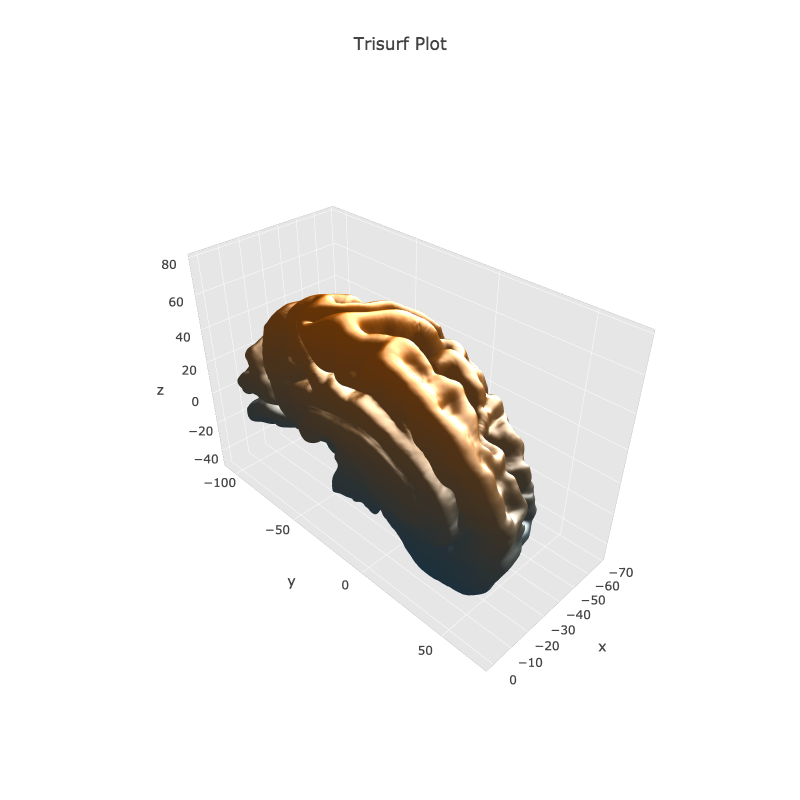

In [8]:
# The lighting parameter can be tweaked to get the look you want
lighting = dict(ambient=.4, specular=1)
fig = ff.create_trisurf(x, y, z, tri, plot_edges=False,
                        aspectratio={'x': .7, 'y': 1.5, 'z': 1})
fig['data'][0]['lighting'] = lighting
# iplot(fig)  # For 3D plotting
Image('./data/trisurf_demo.png')  # Only works if you've saved a PNG

## Plotting with ecogtools
There are a lot of neuroscience-specific visualizations that benefit from 3-D viewing. Ecogtools has a simple module (with lots of room for improvement) to make it easier to plot activity foci on the brain, scatterplots of electrode locations / activity, etc.

Here's a quick way to go from 0 to brains in just a few lines of code:

In [10]:
# We'll initialize a surface object. Eye is the location of the camera
eye = dict(y=0, x=-1.2, z=.1)
surf = et.viz3d.ActivitySurfacePlot(eye=eye, zoom=.8)
surf.add_surface(xyz, tri)

# Read in xyz locations where activity is present
data = h5io.read_hdf5('./data/surface/mne.h5')
mne_xyz = data['xyz']
# Then convert to triangle indices
ixs_activity = np.hstack([surf.find_nearest_triangles(ixyz)
                          for ixyz in mne_xyz])

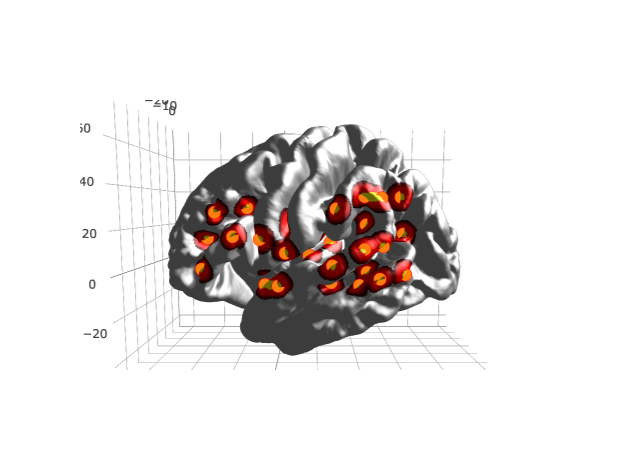

In [12]:
# Finally, set the activity and a scatterplot for a subset of triangles
surf.set_activity(ixs_activity, activity=40, spread=7, vmin=0, vmax=40)
surf.add_scatter_3d(ixs_activity, edgecolor='rgb(255, 0, 0)', s=15)
# fig = surf.plot()  # For 3D plotting
Image('./data/activitysurface_demo.png')   # Only works if you've saved a PNG